In [ ]:
# --- Full modelling pipeline for FLARINIE.xlsx (COLAB) ---
# Copy-paste into a Colab cell and run.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# 0) Make sure the file FLARINIE.xlsx is uploaded to Colab (Files pane) or available at /content/FLARINIE.xlsx
file_path = '/content/FLARINIE.xlsx'   # change if you put it elsewhere

# 1) Robust load: read header row 0 then drop any pre-data rows that are not dates
df_raw = pd.read_excel(file_path, header=0)
print("Initial raw shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())

# Identify which rows contain real dates in the first column and keep them
first_col = df_raw.columns[0]
df_raw['_parsed_date'] = pd.to_datetime(df_raw[first_col], errors='coerce')
print("Number of rows with valid date in first column:", df_raw['_parsed_date'].notna().sum())

# Keep rows that have valid dates
df = df_raw[df_raw['_parsed_date'].notna()].copy()
df['Date'] = pd.to_datetime(df['_parsed_date'])
df = df.drop(columns=['_parsed_date'])
df = df.reset_index(drop=True)
print("After keeping date-rows shape:", df.shape)
display(df.head(6))

# 2) Ensure GBPUSD price column exists and is numeric
if 'GBPUSD' not in df.columns:
    raise ValueError("GBPUSD column not found. Column names: " + str(df.columns.tolist()))
df['GBPUSD'] = pd.to_numeric(df['GBPUSD'], errors='coerce')
print("Non-null GBPUSD count:", df['GBPUSD'].notna().sum())

# 3) Compute daily returns if not already present
if 'GBPUSD Return' not in df.columns:
    df['GBPUSD Return'] = df['GBPUSD'].pct_change()

# Quick check
print("Sample returns count (non-null):", df['GBPUSD Return'].notna().sum())
display(df[['Date','GBPUSD','GBPUSD Return']].head(8))

# 4) Build features (lagged returns, rolling mean/std, momentum)
n_lags = 5
for i in range(1, n_lags+1):
    df[f'GBPUSD_lag_{i}'] = df['GBPUSD Return'].shift(i)

rolling_window = 3
df['GBPUSD_roll_mean'] = df['GBPUSD Return'].rolling(window=rolling_window).mean()
df['GBPUSD_roll_std'] = df['GBPUSD Return'].rolling(window=rolling_window).std()
df['GBPUSD_momentum'] = df['GBPUSD Return'] - df['GBPUSD Return'].shift(1)

# 5) Drop rows with NaNs arising from shifts/rolling (only drop the required subset)
lag_cols = [f'GBPUSD_lag_{i}' for i in range(1, n_lags+1)]
subset_for_drop = lag_cols + ['GBPUSD_roll_mean']  # ensure we have enough history
df_feat = df.dropna(subset=subset_for_drop).reset_index(drop=True)
print("After creating features, shape:", df_feat.shape)
display(df_feat.head(6))

if df_feat.shape[0] == 0:
    raise RuntimeError("No data left after feature engineering. Check FLARINIE.xlsx for continuity or correct columns.")

# 6) Prepare X and y
feature_cols = lag_cols + ['GBPUSD_roll_mean', 'GBPUSD_roll_std', 'GBPUSD_momentum']
X = df_feat[feature_cols].copy()
y = df_feat['GBPUSD Return'].copy()

print("X shape, y shape:", X.shape, y.shape)

# 7) Train-test split (80/20), chronological (shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# 8) Helper: evaluate model (CV on training set + train/test metrics)
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    kf = KFold(n_splits=5, shuffle=False)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    model.fit(X_train, y_train)
    y_tr_pred = model.predict(X_train)
    y_te_pred = model.predict(X_test)
    return {
        'Model': name,
        'CV_R2_mean': np.mean(cv_scores),
        'Train_R2': r2_score(y_train, y_tr_pred),
        'Test_R2': r2_score(y_test, y_te_pred),
        'Train_MAE': mean_absolute_error(y_train, y_tr_pred),
        'Test_MAE': mean_absolute_error(y_test, y_te_pred),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_tr_pred)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_te_pred))
    }, model, y_te_pred, cv_scores

# 9) Baseline Decision Tree (regularized)
dt = DecisionTreeRegressor(max_depth=5, min_samples_split=5, min_samples_leaf=2, random_state=42)
dt_res, dt_trained, dt_ytest_pred, dt_cv = evaluate_model("Decision Tree", dt, X_train, y_train, X_test, y_test)
print("Decision Tree results:", dt_res)

# 10) Baseline Random Forest (regularized)
rf = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=5, min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_res, rf_trained, rf_ytest_pred, rf_cv = evaluate_model("Random Forest", rf, X_train, y_train, X_test, y_test)
print("Random Forest results:", rf_res)

# 11) Hyperparameter tuning for Random Forest (GridSearchCV)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_grid, cv=KFold(n_splits=5, shuffle=False), scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)
print("GridSearch best params:", grid.best_params_)

best_rf = grid.best_estimator_
best_rf_res, best_rf_trained, best_rf_ytest_pred, best_rf_cv = evaluate_model("Tuned Random Forest", best_rf, X_train, y_train, X_test, y_test)
print("Tuned RF results:", best_rf_res)

# 12) Performance table & save
perf = pd.DataFrame([dt_res, rf_res, best_rf_res])
display(perf)
perf.to_csv('/content/model_performance_flarinie.csv', index=False)
print("Saved model_performance_flarinie.csv to /content (use left Files pane to download).")

# 13) Feature importance plot from tuned RF
feat_names = feature_cols
importances = best_rf.feature_importances_

plt.figure(figsize=(7,5))
plt.barh(feat_names, importances)
plt.title("Feature importances (Tuned Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig('/content/feature_importance_flarinie.png', dpi=150)
plt.show()
print("Saved feature importance plot to /content/feature_importance_flarinie.png")

# 14) Save trained tuned model (optional)
import joblib
joblib.dump(best_rf, '/content/best_rf_flarinie.joblib')
print("Saved tuned RF model to /content/best_rf_flarinie.joblib")

# --- Done ---
print("Pipeline finished. If you want, copy the printed outputs here (perf table, best params, or errors).")


FileNotFoundError: [Errno 2] No such file or directory: '/content/FLARINIE.xlsx'

Initial raw shape: (913, 15)
Columns: ['Price', 'GBPUSD', 'DXY', 'Gold_Price', 'SP500', 'DAULY RETRUNS', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'STATISTICAL CALCULATIONS', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']
Number of rows with valid date in first column: 911
After keeping date-rows shape: (911, 16)


,Price,GBPUSD,DXY,Gold_Price,SP500,DAULY RETRUNS,Unnamed: 6,Unnamed: 7,Unnamed: 8,STATISTICAL CALCULATIONS,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Date
0,2021-01-01 00:00:00,1.367301,89.879997,1944.699951,3700.649902,-0.008228,-0.004895,0.004114,0.007083,DXY,100.594709,102.540001,6.008163,89.440002,114.110001,2021-01-01
1,2021-01-04 00:00:00,1.36842,89.879997,1944.699951,3700.649902,0.00427,0.001006,-0.023455,0.00571,Gold Price,1898.261907,1860.400024,163.00574,1623.300049,2433.899902,2021-01-04
2,2021-01-05 00:00:00,1.35716,89.440002,1952.699951,3726.860107,-0.000313,0.003351,0.002832,0.014847,SP500,4346.830607,4306.259766,419.032669,3577.030029,5487.029785,2021-01-05
3,2021-01-06 00:00:00,1.362955,89.529999,1906.900024,3748.139893,-0.004084,0.003006,-0.040893,0.005492,CORRELATION ANALYSIS,NaN,NaN,NaN,NaN,NaN,2021-01-06
4,2021-01-07 00:00:00,1.362528,89.830002,1912.300049,3803.790039,-0.003933,0.004883,0.008451,-0.006555,NaN,GBPUSD Return,DXY Return,Gold Return,SP500 Return,NaN,2021-01-07
5,2021-01-08 00:00:00,1.356963,90.099998,1834.099976,3824.679932,0.000582,-0.005412,-0.003622,0.000416,GBPUSD Return,1,NaN,NaN,NaN,NaN,2021-01-08


Non-null GBPUSD count: 911
Sample returns count (non-null): 910


,Date,GBPUSD,GBPUSD Return
0,2021-01-01,1.367301,NaN
1,2021-01-04,1.368420,0.000818
2,2021-01-05,1.357160,-0.008228
3,2021-01-06,1.362955,0.004270
4,2021-01-07,1.362528,-0.000313
5,2021-01-08,1.356963,-0.004084
6,2021-01-11,1.351625,-0.003933
7,2021-01-12,1.352411,0.000582


After creating features, shape: (905, 25)


,Price,GBPUSD,DXY,Gold_Price,SP500,DAULY RETRUNS,Unnamed: 6,Unnamed: 7,Unnamed: 8,STATISTICAL CALCULATIONS,...,Date,GBPUSD Return,GBPUSD_lag_1,GBPUSD_lag_2,GBPUSD_lag_3,GBPUSD_lag_4,GBPUSD_lag_5,GBPUSD_roll_mean,GBPUSD_roll_std,GBPUSD_momentum
0,2021-01-11 00:00:00,1.351625,90.540001,1849.599976,3799.610107,0.010827,0.002998,0.005806,0.002276,DXY Return,...,2021-01-11,-0.003933,-0.004084,-0.000313,0.004270,-0.008228,0.000818,-0.002777,0.002135,0.000151
1,2021-01-12 00:00:00,1.352411,90.050003,1842.900024,3801.189941,-0.001556,-0.000886,-0.00178,-0.003753,Gold Return,...,2021-01-12,0.000582,-0.003933,-0.004084,-0.000313,0.004270,-0.008228,-0.002479,0.002651,0.004515
2,2021-01-13 00:00:00,1.367054,90.32,1853.599976,3809.840088,0.002518,0.005984,-0.01135,-0.00719,SP500 Return,...,2021-01-13,0.010827,0.000582,-0.003933,-0.004084,-0.000313,0.004270,0.002492,0.007563,0.010245
3,2021-01-14 00:00:00,1.364927,90.239998,1850.300049,3795.540039,-0.007915,0,0,0,NaN,...,2021-01-14,-0.001556,0.010827,0.000582,-0.003933,-0.004084,-0.000313,0.003284,0.006619,-0.012383
4,2021-01-15 00:00:00,1.368363,90.779999,1829.300049,3768.25,0.000435,-0.003084,0.005576,0.008136,NaN,...,2021-01-15,0.002518,-0.001556,0.010827,0.000582,-0.003933,-0.004084,0.003930,0.006311,0.004074
5,2021-01-18 00:00:00,1.357534,90.779999,1829.300049,3768.25,0.004639,-0.000331,0.014352,0.013936,NaN,...,2021-01-18,-0.007915,0.002518,-0.001556,0.010827,0.000582,-0.003933,-0.002318,0.005258,-0.010432


X shape, y shape: (905, 8) (905,)
Train shape: (724, 8) Test shape: (181, 8)
Decision Tree results: {'Model': 'Decision Tree', 'CV_R2_mean': np.float64(0.6721405585609121), 'Train_R2': 0.8486562145025419, 'Test_R2': 0.6345559517728592, 'Train_MAE': 0.0017848579955697917, 'Test_MAE': 0.0019563709815901254, 'Train_RMSE': np.float64(0.0022919554978485333), 'Test_RMSE': np.float64(0.002488495591187118)}
Random Forest results: {'Model': 'Random Forest', 'CV_R2_mean': np.float64(0.8279509963421072), 'Train_R2': 0.9164255931161415, 'Test_R2': 0.8474501395417662, 'Train_MAE': 0.0012335583611980403, 'Test_MAE': 0.001248092742888674, 'Train_RMSE': np.float64(0.0017031799507772813), 'Test_RMSE': np.float64(0.001607801155401878)}
GridSearch best params: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Tuned RF results: {'Model': 'Tuned Random Forest', 'CV_R2_mean': np.float64(0.8941878686211311), 'Train_R2': 0.9653003170476886, 'Test_R2': 0

,Model,CV_R2_mean,Train_R2,Test_R2,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE
0,Decision Tree,0.672141,0.848656,0.634556,0.001785,0.001956,0.002292,0.002488
1,Random Forest,0.827951,0.916426,0.847450,0.001234,0.001248,0.001703,0.001608
2,Tuned Random Forest,0.894188,0.965300,0.934512,0.000639,0.000731,0.001097,0.001053


Saved model_performance_flarinie.csv to /content (use left Files pane to download).


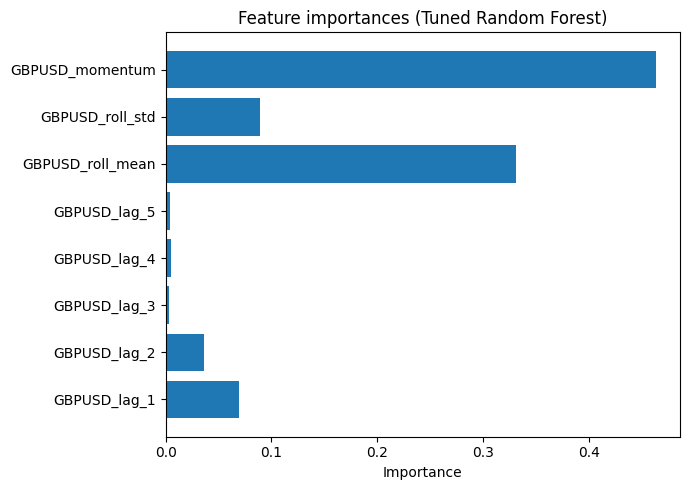

Saved feature importance plot to /content/feature_importance_flarinie.png
Saved tuned RF model to /content/best_rf_flarinie.joblib
Pipeline finished. If you want, copy the printed outputs here (perf table, best params, or errors).


In [ ]:
# --- Full modelling pipeline for FLARINIE.xlsx (COLAB) ---
# Copy-paste into a Colab cell and run.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# 0) Make sure the file FLARINIE.xlsx is uploaded to Colab (Files pane) or available at /content/FLARINIE.xlsx
file_path = '/content/FLARINIE.xlsx'   # change if you put it elsewhere

# 1) Robust load: read header row 0 then drop any pre-data rows that are not dates
df_raw = pd.read_excel(file_path, header=0)
print("Initial raw shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())

# Identify which rows contain real dates in the first column and keep them
first_col = df_raw.columns[0]
df_raw['_parsed_date'] = pd.to_datetime(df_raw[first_col], errors='coerce')
print("Number of rows with valid date in first column:", df_raw['_parsed_date'].notna().sum())

# Keep rows that have valid dates
df = df_raw[df_raw['_parsed_date'].notna()].copy()
df['Date'] = pd.to_datetime(df['_parsed_date'])
df = df.drop(columns=['_parsed_date'])
df = df.reset_index(drop=True)
print("After keeping date-rows shape:", df.shape)
display(df.head(6))

# 2) Ensure GBPUSD price column exists and is numeric
if 'GBPUSD' not in df.columns:
    raise ValueError("GBPUSD column not found. Column names: " + str(df.columns.tolist()))
df['GBPUSD'] = pd.to_numeric(df['GBPUSD'], errors='coerce')
print("Non-null GBPUSD count:", df['GBPUSD'].notna().sum())

# 3) Compute daily returns if not already present
if 'GBPUSD Return' not in df.columns:
    df['GBPUSD Return'] = df['GBPUSD'].pct_change()

# Quick check
print("Sample returns count (non-null):", df['GBPUSD Return'].notna().sum())
display(df[['Date','GBPUSD','GBPUSD Return']].head(8))

# 4) Build features (lagged returns, rolling mean/std, momentum)
n_lags = 5
for i in range(1, n_lags+1):
    df[f'GBPUSD_lag_{i}'] = df['GBPUSD Return'].shift(i)

rolling_window = 3
df['GBPUSD_roll_mean'] = df['GBPUSD Return'].rolling(window=rolling_window).mean()
df['GBPUSD_roll_std'] = df['GBPUSD Return'].rolling(window=rolling_window).std()
df['GBPUSD_momentum'] = df['GBPUSD Return'] - df['GBPUSD Return'].shift(1)

# 5) Drop rows with NaNs arising from shifts/rolling (only drop the required subset)
lag_cols = [f'GBPUSD_lag_{i}' for i in range(1, n_lags+1)]
subset_for_drop = lag_cols + ['GBPUSD_roll_mean']  # ensure we have enough history
df_feat = df.dropna(subset=subset_for_drop).reset_index(drop=True)
print("After creating features, shape:", df_feat.shape)
display(df_feat.head(6))

if df_feat.shape[0] == 0:
    raise RuntimeError("No data left after feature engineering. Check FLARINIE.xlsx for continuity or correct columns.")

# 6) Prepare X and y
feature_cols = lag_cols + ['GBPUSD_roll_mean', 'GBPUSD_roll_std', 'GBPUSD_momentum']
X = df_feat[feature_cols].copy()
y = df_feat['GBPUSD Return'].copy()

print("X shape, y shape:", X.shape, y.shape)

# 7) Train-test split (80/20), chronological (shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# 8) Helper: evaluate model (CV on training set + train/test metrics)
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    kf = KFold(n_splits=5, shuffle=False)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    model.fit(X_train, y_train)
    y_tr_pred = model.predict(X_train)
    y_te_pred = model.predict(X_test)
    return {
        'Model': name,
        'CV_R2_mean': np.mean(cv_scores),
        'Train_R2': r2_score(y_train, y_tr_pred),
        'Test_R2': r2_score(y_test, y_te_pred),
        'Train_MAE': mean_absolute_error(y_train, y_tr_pred),
        'Test_MAE': mean_absolute_error(y_test, y_te_pred),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_tr_pred)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_te_pred))
    }, model, y_te_pred, cv_scores

# 9) Baseline Decision Tree (regularized)
dt = DecisionTreeRegressor(max_depth=5, min_samples_split=5, min_samples_leaf=2, random_state=42)
dt_res, dt_trained, dt_ytest_pred, dt_cv = evaluate_model("Decision Tree", dt, X_train, y_train, X_test, y_test)
print("Decision Tree results:", dt_res)

# 10) Baseline Random Forest (regularized)
rf = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=5, min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_res, rf_trained, rf_ytest_pred, rf_cv = evaluate_model("Random Forest", rf, X_train, y_train, X_test, y_test)
print("Random Forest results:", rf_res)

# 11) Hyperparameter tuning for Random Forest (GridSearchCV)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_grid, cv=KFold(n_splits=5, shuffle=False), scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)
print("GridSearch best params:", grid.best_params_)

best_rf = grid.best_estimator_
best_rf_res, best_rf_trained, best_rf_ytest_pred, best_rf_cv = evaluate_model("Tuned Random Forest", best_rf, X_train, y_train, X_test, y_test)
print("Tuned RF results:", best_rf_res)

# 12) Performance table & save
perf = pd.DataFrame([dt_res, rf_res, best_rf_res])
display(perf)
perf.to_csv('/content/model_performance_flarinie.csv', index=False)
print("Saved model_performance_flarinie.csv to /content (use left Files pane to download).")

# 13) Feature importance plot from tuned RF
feat_names = feature_cols
importances = best_rf.feature_importances_

plt.figure(figsize=(7,5))
plt.barh(feat_names, importances)
plt.title("Feature importances (Tuned Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig('/content/feature_importance_flarinie.png', dpi=150)
plt.show()
print("Saved feature importance plot to /content/feature_importance_flarinie.png")

# 14) Save trained tuned model (optional)
import joblib
joblib.dump(best_rf, '/content/best_rf_flarinie.joblib')
print("Saved tuned RF model to /content/best_rf_flarinie.joblib")

# --- Done ---
print("Pipeline finished. If you want, copy the printed outputs here (perf table, best params, or errors).")


In [ ]:
df_raw.head(), df_raw.shape


(                 Price    GBPUSD        DXY   Gold_Price        SP500  \
 0               Ticker  GBPUSD=X   DX-Y.NYB         GC=F        ^GSPC   
 1                 Date       NaN        NaN          NaN          NaN   
 2  2021-01-01 00:00:00  1.367301  89.879997  1944.699951  3700.649902   
 3  2021-01-04 00:00:00   1.36842  89.879997  1944.699951  3700.649902   
 4  2021-01-05 00:00:00   1.35716  89.440002  1952.699951  3726.860107   
 
    DAULY RETRUNS  Unnamed: 6   Unnamed: 7    Unnamed: 8  \
 0  GBPUSD Return  DXY Return  Gold Return  SP500 Return   
 1       0.000818           0            0             0   
 2      -0.008228   -0.004895     0.004114      0.007083   
 3        0.00427    0.001006    -0.023455       0.00571   
 4      -0.000313    0.003351     0.002832      0.014847   
 
   STATISTICAL CALCULATIONS  Unnamed: 10  Unnamed: 11 Unnamed: 12  Unnamed: 13  \
 0                      NaN         Mean       Median   Std. Dev.         Min.   
 1                   GBPUSD 

In [ ]:
import pandas as pd

# Load again fresh
df = pd.read_excel("/content/FLARINIE.xlsx")

# 1. Remove the first two rows (Ticker + "Date NaN NaN...")
df = df.iloc[2:].reset_index(drop=True)

# 2. Rename columns properly
df.columns = [
    "Date", "GBPUSD", "DXY", "Gold", "SP500",
    "GBPUSD_Return", "DXY_Return", "Gold_Return", "SP500_Return",
    "drop1", "drop2", "drop3", "drop4", "drop5", "drop6", "_parsed_date"
]

# 3. Keep only useful columns
df = df[["Date", "GBPUSD", "DXY", "Gold", "SP500",
         "GBPUSD_Return", "DXY_Return", "Gold_Return", "SP500_Return"]]

# 4. Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# 5. Convert all numeric columns to float
numeric_cols = ["GBPUSD", "DXY", "Gold", "SP500",
                "GBPUSD_Return", "DXY_Return", "Gold_Return", "SP500_Return"]

df[numeric_cols] = df[numeric_cols].astype(float)

df.head(), df.info()


ValueError: Length mismatch: Expected axis has 15 elements, new values have 16 elements

In [ ]:
import pandas as pd

df = pd.read_excel("/content/FLARINIE.xlsx")

# Remove the first 2 rows
df2 = df.iloc[2:].reset_index(drop=True)

print("Number of columns:", len(df2.columns))
print(df2.columns.tolist())


Number of columns: 15
['Price', 'GBPUSD', 'DXY', 'Gold_Price', 'SP500', 'DAULY RETRUNS', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'STATISTICAL CALCULATIONS', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_excel("/content/FLARINIE.xlsx")

# Remove first two rows
df = df.iloc[2:].reset_index(drop=True)

# Rename columns properly
df.columns = [
    "Date", "GBPUSD", "DXY", "Gold",
    "SP500", "GBPUSD_Return", "DXY_Return",
    "Gold_Return", "SP500_Return",
    "Stat_Label", "Mean", "Median",
    "StdDev", "Min", "Max"
]

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Convert numeric columns
num_cols = ["GBPUSD", "DXY", "Gold", "SP500",
            "GBPUSD_Return", "DXY_Return", "Gold_Return", "SP500_Return"]

df[num_cols] = df[num_cols].astype(float)

# Remove the statistical summary rows (they start after GBPAUD data ends)
df = df[df["Stat_Label"].isna()]  # keep only actual daily rows

df = df.drop(columns=["Stat_Label", "Mean", "Median", "StdDev", "Min", "Max"]).reset_index(drop=True)

df.head(), df.shape


(        Date    GBPUSD        DXY         Gold        SP500  GBPUSD_Return  \
 0 2021-01-07  1.362528  89.830002  1912.300049  3803.790039      -0.003933   
 1 2021-01-14  1.364927  90.239998  1850.300049  3795.540039      -0.007915   
 2 2021-01-15  1.368363  90.779999  1829.300049  3768.250000       0.000435   
 3 2021-01-18  1.357534  90.779999  1829.300049  3768.250000       0.004639   
 4 2021-01-19  1.358124  90.500000  1839.500000  3798.909912       0.001777   
 
    DXY_Return  Gold_Return  SP500_Return  
 0    0.004883     0.008451     -0.006555  
 1    0.000000     0.000000      0.000000  
 2   -0.003084     0.005576      0.008136  
 3   -0.000331     0.014352      0.013936  
 4   -0.003758    -0.000322      0.000317  ,
 (903, 9))

In [ ]:
# Create lag features for returns (1 to 5 lags)
for col in ["GBPUSD_Return", "DXY_Return", "Gold_Return", "SP500_Return"]:
    for lag in range(1, 6):
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

# Drop rows with missing lags
df = df.dropna().reset_index(drop=True)

df.head(), df.shape


(        Date    GBPUSD        DXY         Gold        SP500  GBPUSD_Return  \
 0 2021-01-20  1.364424  90.470001  1865.900024  3851.850098       0.004462   
 1 2021-01-21  1.366848  90.129997  1865.300049  3853.070068      -0.003006   
 2 2021-01-22  1.372947  90.239998  1855.699951  3841.469971      -0.000673   
 3 2021-01-25  1.368820  90.389999  1854.900024  3855.360107       0.004573   
 4 2021-01-26  1.367899  90.169998  1850.699951  3849.620117      -0.005249   
 
    DXY_Return  Gold_Return  SP500_Return  GBPUSD_Return_lag1  ...  \
 0    0.001220    -0.005147     -0.003011            0.001777  ...   
 1    0.001662    -0.000431      0.003616            0.004462  ...   
 2   -0.002434    -0.002264     -0.001489           -0.003006  ...   
 3    0.005323    -0.003134     -0.025678           -0.000673  ...   
 4   -0.002096    -0.003794      0.009761            0.004573  ...   
 
    Gold_Return_lag1  Gold_Return_lag2  Gold_Return_lag3  Gold_Return_lag4  \
 0         -0.000322    

In [ ]:
from sklearn.model_selection import train_test_split

# Define target and features
target = "GBPUSD_Return"

# All other columns except Date & target are features
feature_cols = [col for col in df.columns if col not in ["Date", target]]

X = df[feature_cols]
y = df[target]

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((716, 27), (180, 27), (716,), (180,))

In [ ]:
df['GBPUSD_Returns'] = df['GBPUSD'].pct_change()


In [ ]:
df.head()


,Date,GBPUSD,DXY,Gold,SP500,GBPUSD_Return,DXY_Return,Gold_Return,SP500_Return,GBPUSD_Return_lag1,...,Gold_Return_lag2,Gold_Return_lag3,Gold_Return_lag4,Gold_Return_lag5,SP500_Return_lag1,SP500_Return_lag2,SP500_Return_lag3,SP500_Return_lag4,SP500_Return_lag5,GBPUSD_Returns
0,2021-01-20,1.364424,90.470001,1865.900024,3851.850098,0.004462,0.001220,-0.005147,-0.003011,0.001777,...,0.014352,0.005576,0.000000,0.008451,0.000317,0.013936,0.008136,0.000000,-0.006555,NaN
1,2021-01-21,1.366848,90.129997,1865.300049,3853.070068,-0.003006,0.001662,-0.000431,0.003616,0.004462,...,-0.000322,0.014352,0.005576,0.000000,-0.003011,0.000317,0.013936,0.008136,0.000000,0.001777
2,2021-01-22,1.372947,90.239998,1855.699951,3841.469971,-0.000673,-0.002434,-0.002264,-0.001489,-0.003006,...,-0.005147,-0.000322,0.014352,0.005576,0.003616,-0.003011,0.000317,0.013936,0.008136,0.004462
3,2021-01-25,1.368820,90.389999,1854.900024,3855.360107,0.004573,0.005323,-0.003134,-0.025678,-0.000673,...,-0.000431,-0.005147,-0.000322,0.014352,-0.001489,0.003616,-0.003011,0.000317,0.013936,-0.003006
4,2021-01-26,1.367899,90.169998,1850.699951,3849.620117,-0.005249,-0.002096,-0.003794,0.009761,0.004573,...,-0.002264,-0.000431,-0.005147,-0.000322,-0.025678,-0.001489,0.003616,-0.003011,0.000317,-0.000673


In [ ]:
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop(columns=['Date', 'GBPAUD_Return'])  # Drop target & date
y = df['GBPAUD_Return']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


KeyError: "['GBPAUD_Return'] not found in axis"

In [ ]:
# Correct target column
X = df.drop(columns=['Date', 'GBPUSD_Return'])  # Features
y = df['GBPUSD_Return']                        # Target


In [ ]:
# Create GBPAUD returns if you have a GBPAUD price column
df['GBPAUD_Return'] = df['GBPAUD'].pct_change()  # Daily returns
df.dropna(inplace=True)  # Drop first row with NaN


KeyError: 'GBPAUD'

In [ ]:
print(df.columns.tolist())


['Date', 'GBPUSD', 'DXY', 'Gold', 'SP500', 'GBPUSD_Return', 'DXY_Return', 'Gold_Return', 'SP500_Return', 'GBPUSD_Return_lag1', 'GBPUSD_Return_lag2', 'GBPUSD_Return_lag3', 'GBPUSD_Return_lag4', 'GBPUSD_Return_lag5', 'DXY_Return_lag1', 'DXY_Return_lag2', 'DXY_Return_lag3', 'DXY_Return_lag4', 'DXY_Return_lag5', 'Gold_Return_lag1', 'Gold_Return_lag2', 'Gold_Return_lag3', 'Gold_Return_lag4', 'Gold_Return_lag5', 'SP500_Return_lag1', 'SP500_Return_lag2', 'SP500_Return_lag3', 'SP500_Return_lag4', 'SP500_Return_lag5', 'GBPUSD_Returns']


In [ ]:
df.columns = df.columns.str.strip()


In [ ]:
# Strip any extra spaces from column names
df.columns = df.columns.str.strip()

# Check that your target exists
'GBPAUD_Return' in df.columns


False

In [ ]:
print(df.columns.tolist())


['Date', 'GBPUSD', 'DXY', 'Gold', 'SP500', 'GBPUSD_Return', 'DXY_Return', 'Gold_Return', 'SP500_Return', 'GBPUSD_Return_lag1', 'GBPUSD_Return_lag2', 'GBPUSD_Return_lag3', 'GBPUSD_Return_lag4', 'GBPUSD_Return_lag5', 'DXY_Return_lag1', 'DXY_Return_lag2', 'DXY_Return_lag3', 'DXY_Return_lag4', 'DXY_Return_lag5', 'Gold_Return_lag1', 'Gold_Return_lag2', 'Gold_Return_lag3', 'Gold_Return_lag4', 'Gold_Return_lag5', 'SP500_Return_lag1', 'SP500_Return_lag2', 'SP500_Return_lag3', 'SP500_Return_lag4', 'SP500_Return_lag5', 'GBPUSD_Returns']


In [ ]:
# Example: rename to standard column name
df.rename(columns={' GBPAUD_Return ': 'GBPAUD_Return'}, inplace=True)


In [ ]:
df.columns = df.columns.str.strip()


In [ ]:
'GBPAUD_Return' in df.columns  # Should return True


False

In [ ]:
# Use GBPUSD_Return as target
X = df.drop(columns=['Date', 'GBPUSD_Return'])
y = df['GBPUSD_Return']


In [ ]:
import yfinance as yf

# Download GBPAUD historical data
gbpaud = yf.download('GBPAUD=X', start='2021-01-01', end='2021-12-31')

# Calculate daily returns
gbpaud['GBPAUD_Return'] = gbpaud['Adj Close'].pct_change()
gbpaud.dropna(inplace=True)

# Merge with your existing features dataset on Date
df = df.merge(gbpaud['GBPAUD_Return'], left_on='Date', right_index=True)


[*********************100%***********************]  1 of 1 completed


KeyError: 'Adj Close'

In [ ]:
import yfinance as yf

gbpaud = yf.download('GBPAUD=X', start='2021-01-01', end='2021-12-31')
print(gbpaud.head())
print(gbpaud.columns)


[*********************100%***********************]  1 of 1 completed

Price         Close     High       Low     Open   Volume
Ticker     GBPAUD=X GBPAUD=X  GBPAUD=X GBPAUD=X GBPAUD=X
Date                                                    
2021-01-01  1.76041  1.77660  1.500208  1.75643        0
2021-01-04  1.77420  1.77893  1.763490  1.77417        0
2021-01-05  1.76940  1.77058  1.756840  1.76945        0
2021-01-06  1.75470  1.75768  1.743280  1.75516        0
2021-01-07  1.74296  1.75632  1.741620  1.74288        0
MultiIndex([( 'Close', 'GBPAUD=X'),
            (  'High', 'GBPAUD=X'),
            (   'Low', 'GBPAUD=X'),
            (  'Open', 'GBPAUD=X'),
            ('Volume', 'GBPAUD=X')],
           names=['Price', 'Ticker'])


In [ ]:
# Select GBPAUD Close price
gbpaud_close = gbpaud[('Close', 'GBPAUD=X')]


In [ ]:
gbpaud_returns = gbpaud_close.pct_change().dropna()
gbpaud_returns.name = 'GBPAUD_Return'


In [ ]:
# Ensure Date columns are datetime
df['Date'] = pd.to_datetime(df['Date'])
gbpaud_returns.index = pd.to_datetime(gbpaud_returns.index)

# Merge
df = df.merge(gbpaud_returns, left_on='Date', right_index=True, how='left')


In [ ]:
X = df.drop(columns=['Date', 'GBPAUD_Return'])
y = df['GBPAUD_Return']


In [ ]:
# -------------------------------
# 1. IMPORT LIBRARIES
# -------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 2. FEATURES AND TARGET
# -------------------------------
# Drop Date and target column
X = df.drop(columns=['Date', 'GBPAUD_Return'])
y = df['GBPAUD_Return']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# 3. MODEL INITIALIZATION
# -------------------------------
# Random Forest
rf_model = RandomForestRegressor(random_state=42)

# XGBoost
xgb_model = XGBRegressor(
    random_state=42,
    objective='reg:squarederror'
)

# -------------------------------
# 4. CROSS-VALIDATION
# -------------------------------
rf_cv = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
xgb_cv = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')

print("Random Forest 5-fold CV R2:", np.mean(rf_cv))
print("XGBoost 5-fold CV R2:", np.mean(xgb_cv))

# -------------------------------
# 5. TRAIN MODELS
# -------------------------------
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# -------------------------------
# 6. MODEL EVALUATION FUNCTION
# -------------------------------
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
    }
    return metrics

# Evaluate
rf_metrics = evaluate_model(rf_model, X_train, y_train, X_test, y_test)
xgb_metrics = evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

print("Random Forest Metrics:", rf_metrics)
print("XGBoost Metrics:", xgb_metrics)

# -------------------------------
# 7. HYPERPARAMETER TUNING (Random Forest example)
# -------------------------------
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

print("Best RF parameters:", grid_rf.best_params_)

# Re-evaluate best RF
best_rf = grid_rf.best_estimator_
best_rf_metrics = evaluate_model(best_rf, X_train, y_train, X_test, y_test)
print("Tuned Random Forest Metrics:", best_rf_metrics)

# -------------------------------
# 8. FEATURE IMPORTANCE (Random Forest)
# -------------------------------
feature_importance = pd.Series(best_rf.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# -------------------------------
# 9. OPTIONAL: LEARNING CURVE
# -------------------------------
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train R2')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test R2')
plt.xlabel('Training Size')
plt.ylabel('R2 Score')
plt.title('Learning Curve - Random Forest')
plt.legend()
plt.show()


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py", line 360, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 1387, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 1397, in _check_y
    y = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 1107, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input y contains NaN.


In [ ]:
# Drop rows where GBPAUD_Return is NaN
df = df.dropna(subset=['GBPAUD_Return'])

# Optional: reset index
df.reset_index(drop=True, inplace=True)


In [ ]:
X = df.drop(columns=['Date', 'GBPAUD_Return'])
y = df['GBPAUD_Return']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')


array([ 0.12186947, -0.01496814,  0.05580848, -0.23117015,  0.09822683])

In [ ]:
import numpy as np
cv_mean = np.mean([0.12186947, -0.01496814, 0.05580848, -0.23117015, 0.09822683])
print(cv_mean)


0.005953297999999998


Best RF params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best XGB params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
               Train R2   Test R2  Train MAE  Test MAE  Train RMSE  Test RMSE
Random Forest  0.862616 -0.045181   0.001116  0.002967    0.001418   0.003797
XGBoost        0.568511 -0.083605   0.001933  0.003057    0.002513   0.003866


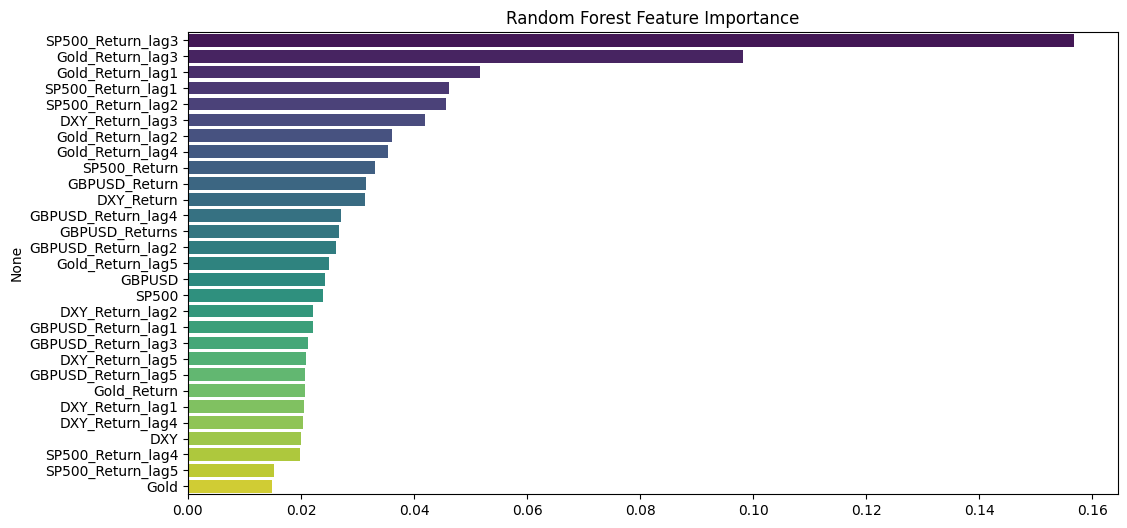

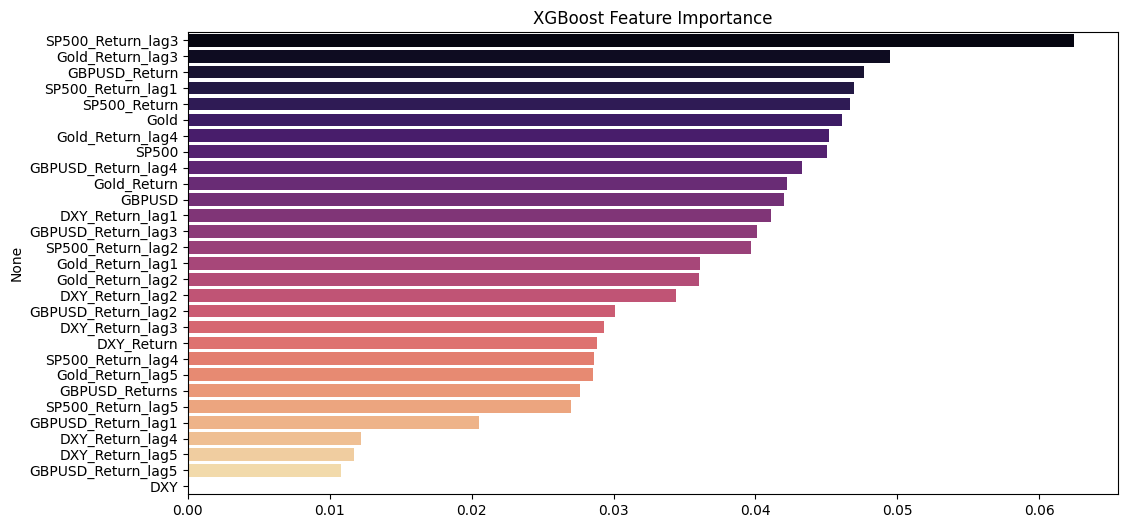

In [ ]:
# -------------------------------
# 1. IMPORT LIBRARIES (if not already)
# -------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 2. FEATURES AND TARGET
# -------------------------------
X = df.drop(columns=['Date', 'GBPAUD_Return'])
y = df['GBPAUD_Return']

# Ensure no NaNs
df = df.dropna(subset=['GBPAUD_Return'])
X = df.drop(columns=['Date', 'GBPAUD_Return'])
y = df['GBPAUD_Return']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# 3. DEFINE MODELS
# -------------------------------
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

# -------------------------------
# 4. HYPERPARAMETER TUNING
# -------------------------------

# Random Forest grid
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(rf, rf_params, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("Best RF params:", grid_rf.best_params_)

# XGBoost grid
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_xgb = GridSearchCV(xgb, xgb_params, cv=5, scoring='r2', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print("Best XGB params:", grid_xgb.best_params_)

# -------------------------------
# 5. EVALUATION FUNCTION
# -------------------------------
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    metrics = {
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
    }
    return metrics

# -------------------------------
# 6. EVALUATE BOTH MODELS
# -------------------------------
rf_metrics = evaluate_model(best_rf, X_train, y_train, X_test, y_test)
xgb_metrics = evaluate_model(best_xgb, X_train, y_train, X_test, y_test)

# Performance table
performance = pd.DataFrame([rf_metrics, xgb_metrics], index=['Random Forest', 'XGBoost'])
print(performance)

# -------------------------------
# 7. FEATURE IMPORTANCE
# -------------------------------
# Random Forest
rf_importance = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=rf_importance.values, y=rf_importance.index, palette="viridis")
plt.title("Random Forest Feature Importance")
plt.show()

# XGBoost
xgb_importance = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=xgb_importance.values, y=xgb_importance.index, palette="magma")
plt.title("XGBoost Feature Importance")
plt.show()


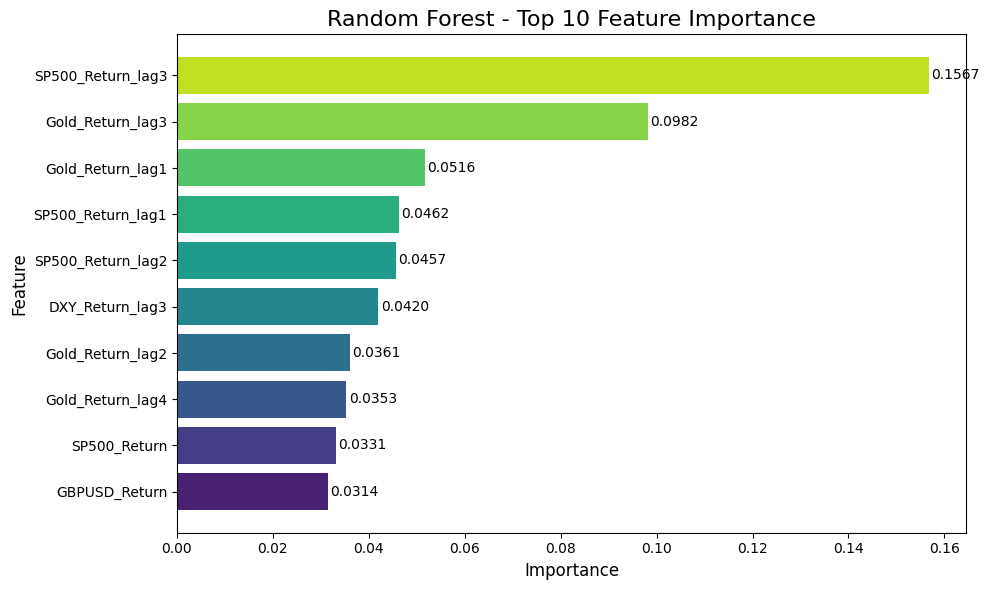

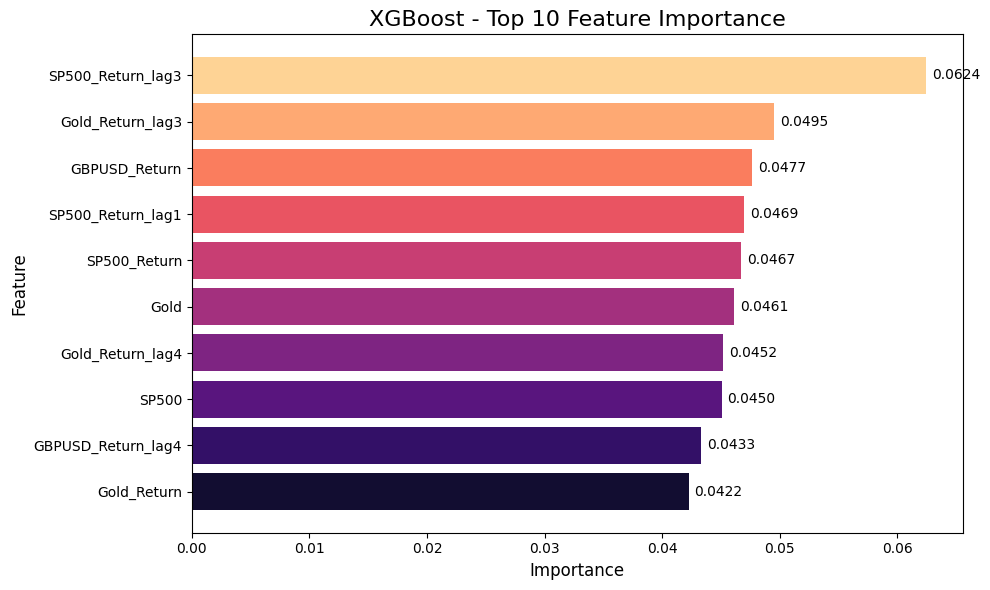

In [ ]:
def plot_feature_importance(importances, model_name, top_n=10, palette="viridis"):
    # Convert to series and sort
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    feat_imp_top = feat_imp.head(top_n)[::-1]  # top_n features, reversed for horizontal bar

    plt.figure(figsize=(10,6))
    bars = plt.barh(feat_imp_top.index, feat_imp_top.values, color=sns.color_palette(palette, top_n))

    # Add value labels to bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.0005, bar.get_y() + bar.get_height()/2,
                 f"{width:.4f}", va='center', fontsize=10)

    plt.title(f"{model_name} - Top {top_n} Feature Importance", fontsize=16)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot Random Forest
plot_feature_importance(best_rf.feature_importances_, "Random Forest", top_n=10, palette="viridis")

# Plot XGBoost
plot_feature_importance(best_xgb.feature_importances_, "XGBoost", top_n=10, palette="magma")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

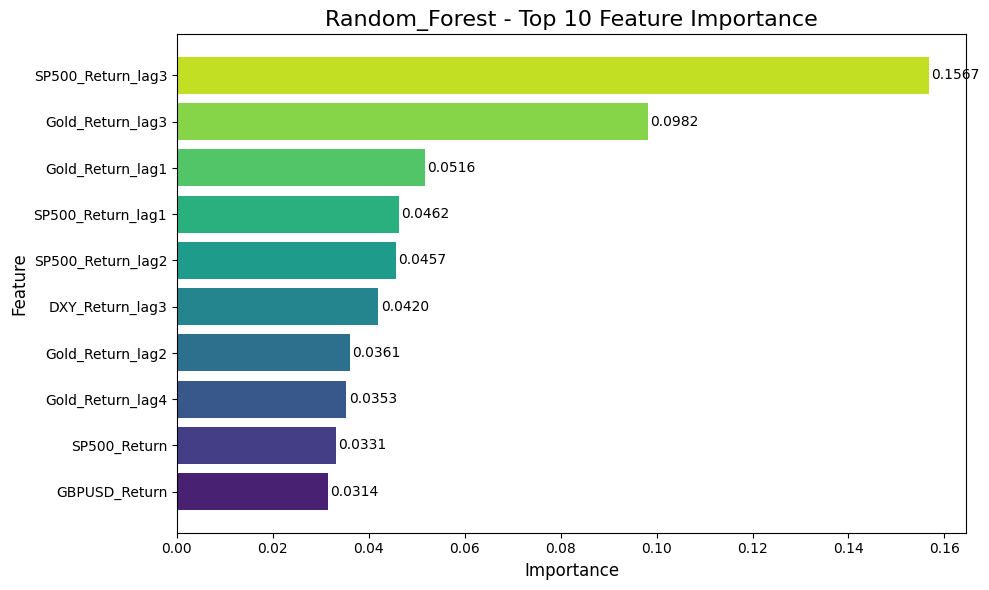

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

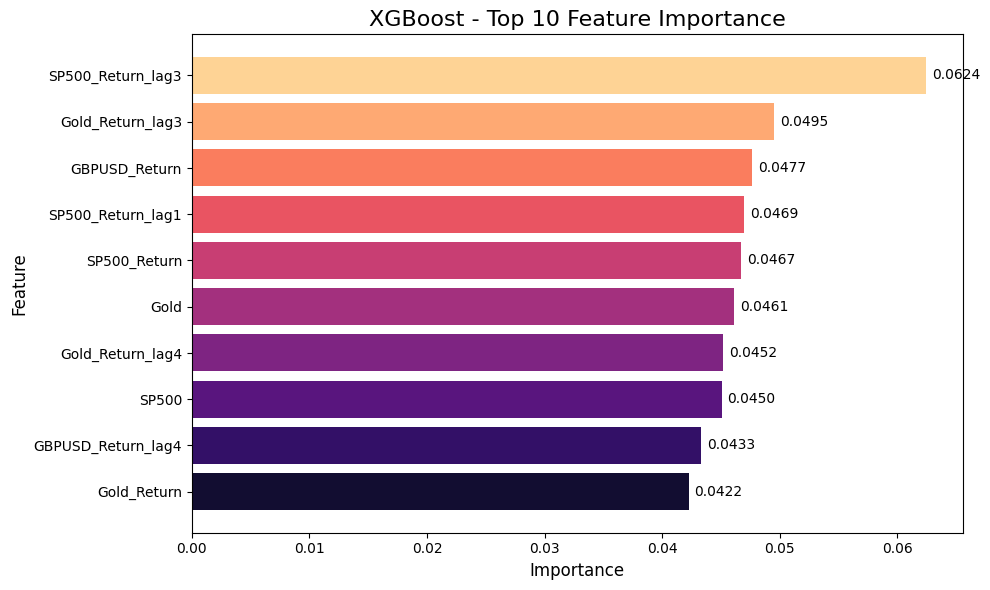

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_and_download_feature_importance(importances, model_name, top_n=10, palette="viridis"):
    # Convert to Series and sort
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    feat_imp_top = feat_imp.head(top_n)[::-1]  # top_n features, reversed for horizontal bar

    plt.figure(figsize=(10,6))
    bars = plt.barh(feat_imp_top.index, feat_imp_top.values, color=sns.color_palette(palette, top_n))

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.0005, bar.get_y() + bar.get_height()/2,
                 f"{width:.4f}", va='center', fontsize=10)

    plt.title(f"{model_name} - Top {top_n} Feature Importance", fontsize=16)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()

    # Save and download
    filename = f"{model_name}_feature_importance.png"
    plt.savefig(filename, dpi=300)
    files.download(filename)
    plt.show()

# Plot and download Random Forest top 10 features
plot_and_download_feature_importance(best_rf.feature_importances_, "Random_Forest", top_n=10, palette="viridis")

# Plot and download XGBoost top 10 features
plot_and_download_feature_importance(best_xgb.feature_importances_, "XGBoost", top_n=10, palette="magma")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

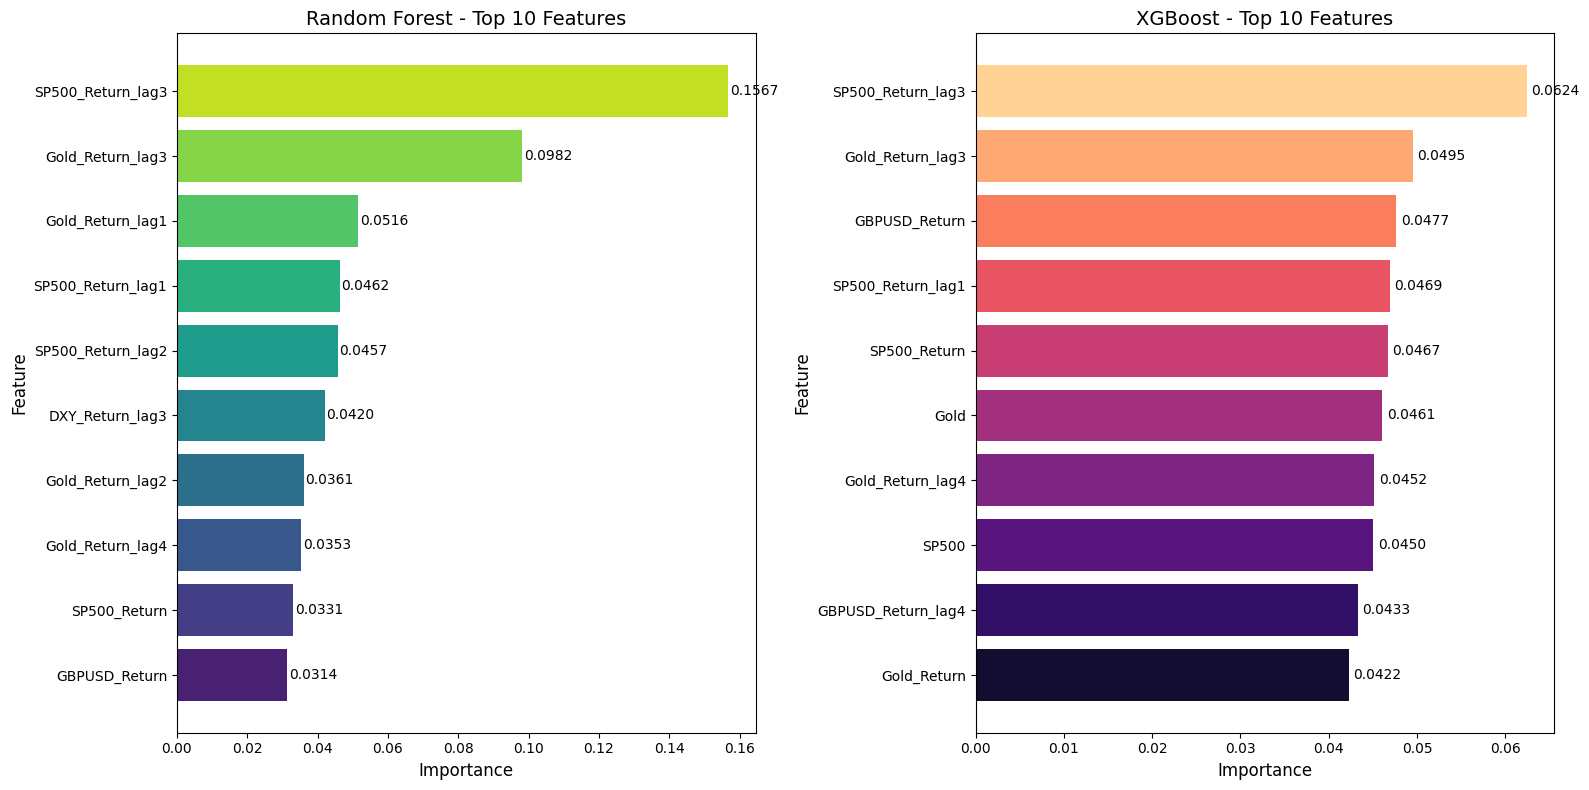

In [ ]:
plt.figure(figsize=(16,8))

# -------------------------------
# Random Forest
# -------------------------------
plt.subplot(1,2,1)
rf_imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)[::-1]
bars1 = plt.barh(rf_imp.index, rf_imp.values, color=sns.color_palette("viridis", 10))
for bar in bars1:
    plt.text(bar.get_width() + 0.0005, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.4f}", va='center', fontsize=10)
plt.title("Random Forest - Top 10 Features", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# -------------------------------
# XGBoost
# -------------------------------
plt.subplot(1,2,2)
xgb_imp = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)[::-1]
bars2 = plt.barh(xgb_imp.index, xgb_imp.values, color=sns.color_palette("magma", 10))
for bar in bars2:
    plt.text(bar.get_width() + 0.0005, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.4f}", va='center', fontsize=10)
plt.title("XGBoost - Top 10 Features", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)

plt.tight_layout()
plt.savefig("Feature_Importance_Comparison.png", dpi=300)
from google.colab import files
files.download("Feature_Importance_Comparison.png")
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

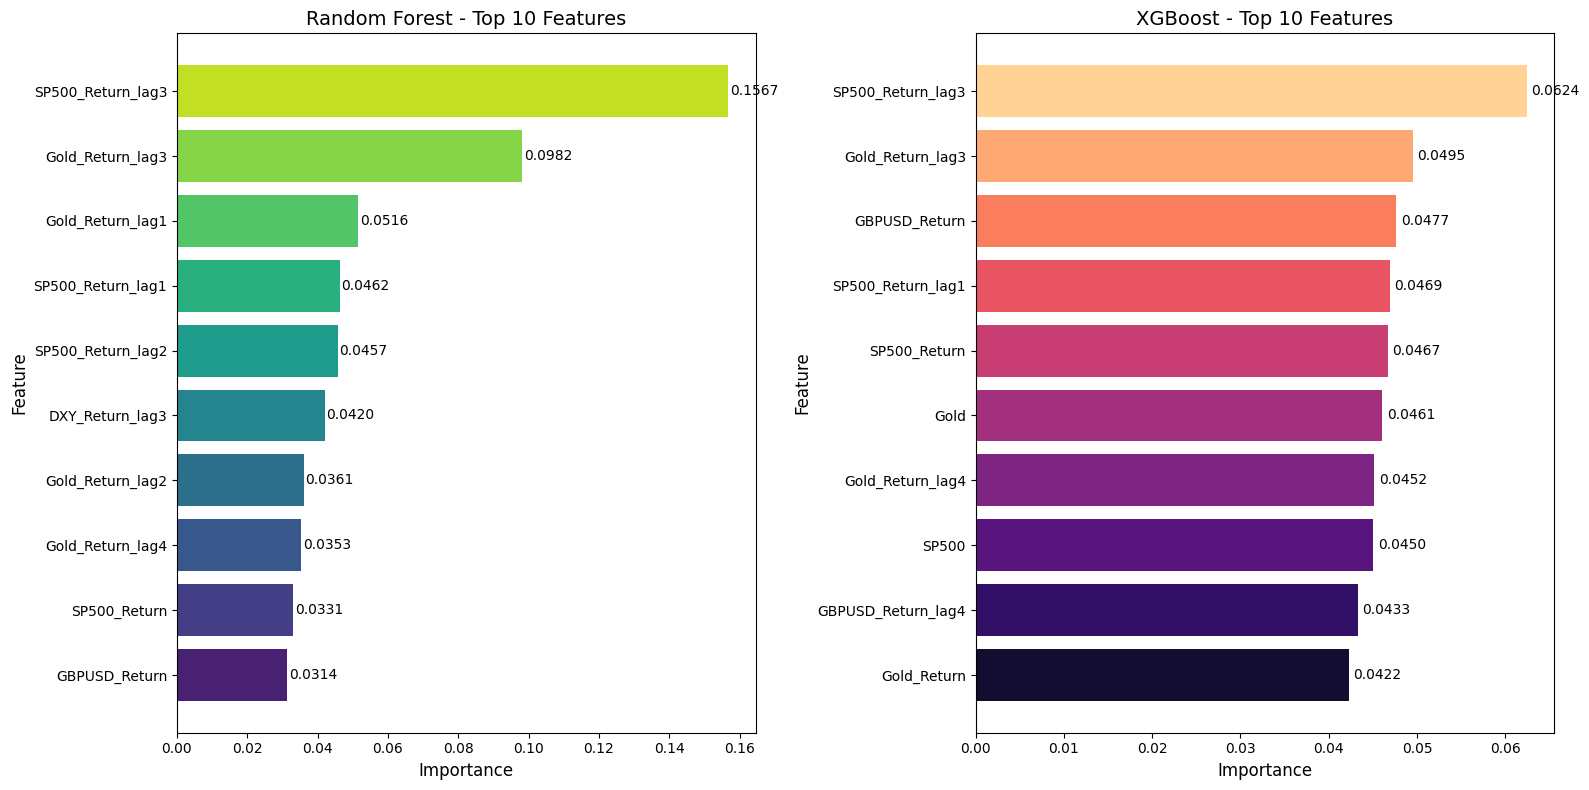

In [ ]:
plt.figure(figsize=(16,8))

# -------------------------------
# Random Forest
# -------------------------------
plt.subplot(1,2,1)
rf_imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)[::-1]
colors_rf = sns.color_palette("viridis", len(rf_imp))  # gradient based on importance
bars1 = plt.barh(rf_imp.index, rf_imp.values, color=colors_rf)
for bar in bars1:
    plt.text(bar.get_width() + 0.0005, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.4f}", va='center', fontsize=10)
plt.title("Random Forest - Top 10 Features", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# -------------------------------
# XGBoost
# -------------------------------
plt.subplot(1,2,2)
xgb_imp = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)[::-1]
colors_xgb = sns.color_palette("magma", len(xgb_imp))  # gradient based on importance
bars2 = plt.barh(xgb_imp.index, xgb_imp.values, color=colors_xgb)
for bar in bars2:
    plt.text(bar.get_width() + 0.0005, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.4f}", va='center', fontsize=10)
plt.title("XGBoost - Top 10 Features", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)

plt.tight_layout()
plt.savefig("Feature_Importance_Comparison_Gradient.png", dpi=300)
from google.colab import files
files.download("Feature_Importance_Comparison_Gradient.png")
plt.show()
